# Sample Complexity Gaps

## Abstract
Why do convolutional neural networks (CNNs) learn with less data than fully connected networks (FCNs)? (Write about what prevailing theories point to -> VC, and then specific models, and then specific tasks and algorithms)

**In this project**, We construct an image classification task based on the Fourier Transform, and empirically demonstrate a sample complexity gap on realistic CNN and FCN architectures. *Our claim is weak* - that for our chosen arrangement of models, learning rates, image range, labelling function, and learning algorithm, in an abundance of training data, our CNN learns with an estimated $O(1)$ samples, and our FCN learns with an estimated $\Omega(D^{2})$ samples. The value of this work is to better grasp what kind of natural tasks strongly distinguish the capabilities of CNNs and FCNs.


## Introduction

#### Motivation

In a world of finite data, the sample efficiency of comparable models can be an important factor for deciding which model to choose. Ideally, you would like make an estimate of the number of data points you would need based off the task, architecture, training algorithm, and required accuracy. A relevant theoretical quantity from VC theory is *sample complexity* which, informally, is the number of training samples required for a learning algorithm to converge with high probability to a hypothesis (model weights) that's close to the best in its class (model architecture). Typically, we are also interested in how the sample complexity relates to the input dimension - how much more data is necessary if I learn to classify $256 \times 256$ images rather than $128 \times 128$?

#### Sample complexity bounds
**Vapnik-Chervonenkis theory** provides an initial answer to this question by way of a theorem. A hypothesis class $\mathcal{H}=\{h:X\rightarrow Y\}$ is said to be $(\epsilon, \delta)$-PAC-learnable if there exists an algorithm $\mathcal{A}$ and a minimum sample size function $m_{\mathcal{H}}(\epsilon, \delta)$ such that for any distribution $\mathcal{D}$ over the input and output spaces $(X, Y)$, the true loss of the hypothesis $\mathcal{A}(\mathcal{S})$, where $S\sim\mathcal{D}^m$ for every $m \geq m_\mathcal{H}(\epsilon, \delta)$ is within a tolerance $\epsilon$ of the true loss of the best hypothesis $h^*\in\mathcal{H}$, with probability at least $1-\delta$.

$$\mathbb{P}\{L_\mathcal{D}(\mathcal{A}(\mathcal{S})) \leq L_\mathcal{D}(h^*)+\epsilon \} \geq 1-\delta$$

When $\mathcal{H}$ is the potentially infinite class of binary functions, then $\mathcal{H}$ is $(\epsilon, \delta)$-PAC-learnable with a sample of size $m_{\mathcal{H}}(\epsilon, \delta)=O(\frac{1}{\epsilon}(VC(\mathcal{H}) + \ln{\frac{1}{\delta}}))$, where $VC(\mathcal{H})$ is the VC dimension of $\mathcal{H}$. For two-layer piecewise linear neural networks such as the FCN in this paper, the VC dimension has been shown to be $\mathcal{O}(W\log{W})$ in the number of parameters $W$. [1] For 

## Related work
Why are convolutional nets more sample -
efficient than fully-connected nets ? [Li (2020)](https://arxiv.org/pdf/2010.08515.pdf)

An Optimization and Generalization Analysis for Max-Pooling Networks [Brutzkus (2021)](https://arxiv.org/pdf/2002.09781.pdf)

## Methods

We compare two models on two binary square image classification tasks.

### Tasks
Let $L$ be the image width, so $D:=L^2$ is the input dimension with $\mathcal{X}\subset \mathbb{R}^D$.
1. **Difference of p-norms (DOp)**
+ An input is an entry-wise normal square image $\mathcal{X} \ni X \sim \mathcal{N}(0, 1)^D$.

+ For $p>0$, define the labelling function $h_p(X)=\mathcal{1}[\sum_{i=1}^{D/2}x_i^p >\sum_{i=D/2 +1}^{D}x_i^p]$, where the pixels $x_i$ of $X$ are indexed in column-order.

+ Then $Y=h_p(X)$ is the corresponding label in $\{0, 1\}$. It tells you if the left side of the image is "brighter" than the right".
2. **Noisy Fourier patterns (NFP)**
+ Create a blank Fourier-domain square image $\dot{X}$ of side length $L$. 

+ Assign random complex units of $f=8$ random points in a low-pass box of side-length $L/2$ inside $\dot{X}$.

+ Then compute $|IFT(\dot{X})|$ with pixel-wise modulus and standardize the pixel values to mean $0$ and variance $1$. Call this $M$.

+ Generate a label $Y\sim \text{Ber}(p)$ in $\{0, 1\}$ with parameter $p=0.5$. If $Y=1$, obfuscate $M$ with noise $Z\sim \mathcal{N}(0, 1)^d$. 

+ Finally, $X = L^2\frac{M + YZ}{(||M + YZ||_1+10^{-6})}$
### Models
We compare a standard convolutional neural network with a max-pooling and linear layer to a two-layer neural network. Well-known learning theory results tells us that the number of parameters is a confounder on the sample complexity, so we match the number of parameters of the FCN to that of the CNN as best as possible by adjusting the number of hidden neurons $H$ in the FCN.
1. **Convolutional neural network** (CNN)
    + Convolutional layer : $1$ in channel, $1000$ out channels, kernel size $3$, stride $1$, padding $1$
    + Activation layer : $ReLU$
    + Max pool layer : kernel size $2$, stride $2$
    + Linear layer : ? in, $1$ out neuron
    + Sigmoid layer : $\sigma$
2. **Fully connected Network** (FCN)
    + Linear layer : $L^2$ in, $H$ out neurons
    + Activation layer : $ReLU$
    + Linear layer : $H$ in, $1$ out neuron
    + Sigmoid layer : $\sigma$

If the CNN has $|CNN|$ parameters, then let $H=\max\{1, \lceil |CNN| / (L^2+1)\rceil - 1\}$
### The training and testing protocols
+ We train with Adam and Binary Cross Entropy Loss, with freshly generated image batches of size $64$ since we assume an abundace of training data.
+ When the model obtains a training loss of 0.5, we test the model against a set of $1000$ fixed image-label pairs and compute accuracy $\alpha$.
+ If the obtained accuracy surpasses the requirement $\alpha > \epsilon$, then stop and record the number of training batches for that image size. \
Otherwise, lower the training loss goal by $0.025$ and continue training on new batches.
+ The learning rates $\eta$ and accuracy goals $\epsilon$ we used are summarized in this table.

|  | CNN $\eta$ | FCN $\eta$ | $\epsilon$ |
|:-------:|---------|-----|---|
| NFP | 0.00005 | 0.005 | 0.80 |
| DO1 | 0.00005  | 0.005 | 0.80|
| DO2 | 0.0001  | 0.001 | 0.80 |

### The measurement
For a range of image sizes $L\in\{10,12,14\dots,40\}$ and a given task, we train both models on fresh batches of 64 training samples until the model hits the required accuracy $\epsilon=0.75$ on the held-out test set, and record the number of batches. We do this a total of $5$ times per model and task, and then fit a polynomial model of the form $ax^b$ with $a, b\in\mathbb{R}_{\geq 0}$ to the results in order to get the estimate $\Omega(d^b)$.


# Experiment

In [216]:
# Imports
import os
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from itertools import product
from helpers import *
from models import ModelLoader

We define the fixed experiment parameters and particular setting.

In [232]:
# Fixed variables
Ls              = np.arange(10, 40+1, 2) # Image side lengths
channels        = 1     # Image channels
input_shapes    = [(channels, L, L) for L in Ls]
N_te            = 1_000 # Test set
f               = 8     # Number of distinct frequencies            
epsilon         = 0.8  # Required accuracy
batch_size      = 64    # Batch size
cnn_out_chans   = 1000  # The number of output channels in the CNN model

# Experiment controls
delete          = False # Delete results of previous runs for that model.
relative        = True  # The box scales with the image size
balance         = False # Balance the results of the previous runs in case of stopping

# Particular setting
architecture    = "FCNN" # Codes are FCNN or CNN 
activation      = "ReLU"
task_name       = "NFP" # Codes are DO1, DO2, or NFP
arch_name       = architecture + "+" + activation
learning_rate   = 0.005
estimates       = 5
filepath        = f'results/week14/task{task_name}_acc{str(epsilon)}_freq{f}.pkl' # Results file

We create, delete, or balance out the results file in case of an incomplete run.

In [233]:
# Create file if it doesn't exist
with open(filepath, 'ab+') as file:
    if os.stat(filepath).st_size == 0:
        pickle.dump(dict(), file)

# Option del - delete contents of results file
if delete:
    with open(filepath, 'rb+') as file:
        results = pickle.load(file)

    # Filter out results with same name
    with open(filepath, 'wb+') as file:
        filtered = {(name, size) : val for (name, size), val in results.items() if name!=arch_name}
        pickle.dump(filtered, file)

# Option balance - balance previous results
if balance:        
    with open(filepath, 'rb+') as file:
        results = pickle.load(file)

        # The minumum number of runs from previous
        min_runs = min([len(res) for (name, size), res in results.items() if name==arch_name])

    # Filter out results with same name
    with open(filepath, 'wb+') as file:
        balanced = {(name, size): res[:min_runs] if name==arch_name else res for (name, size), res in results.items()}
        pickle.dump(balanced, file)


We deploy a GPU if it is available.

In [234]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, "\n")

# Don't try to use CuDNN with Tesla GPU
torch.backends.cudnn.enabled = False

# GPU has not a lot of memory, so empty cache
torch.cuda.empty_cache() 

# Avoid fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256" 

Using device:  cpu 



## Data generation
We set up the scripts to generate data for the two tasks.

### Task 1 - Difference of p-norms

In [220]:
def gen_DOP_data(L=10, N=1, p=2):
    """
        Generates data for the difference of p-norms task.
        
        Parameters:
            L: image width 
            N: number of samples to generate
            p: the norm
        Returns:
            x: the noisy image tensor of shape (N, 1, L, L)
            y: the label tensor of shape (N, 1)
    """
    
    # Pixel-wise standard normal
    x = torch.tensor(np.random.normal(0,1,size=(N, 1, L, L)), dtype=torch.float32)
    
    # Left and right norms across the image dimensions
    l_norm = torch.sum(x[:, :, :, L//2:]**p, dim=(2, 3))
    r_norm = torch.sum(x[:, :, :, :L//2]**p, dim=(2, 3))
    
    # Label : 1 if the left norm is higher than the right
    y = (l_norm > r_norm).type(dtype=torch.float32)

    # Return data and labels
    return x, y

Here's are some samples

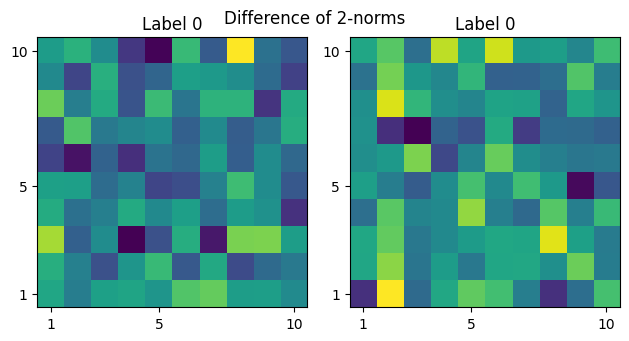

In [221]:
L = 10; p=2; N=2
ticks = np.array([0, L//2-1, L-1])
x, y = gen_DOP_data(L, N, p)
fig, axs = plt.subplots(ncols=N)
for i, ax in enumerate(axs):
    ax.imshow(x[i, 0], origin='lower')
    ax.set_title(f"Label {int(y[i, 0])}")
    ax.set_xticks(ticks); ax.set_xticklabels(ticks+1)
    ax.set_yticks(ticks); ax.set_yticklabels(ticks+1)

fig.tight_layout()
fig.suptitle(f"Difference of {p}-norms", y= 0.84)
plt.show()

### Task 2 - Noisy Fourier Patterns

In [222]:
def gen_NFP_data(L, N, f, clamp, channels=1):

    """
        Generates data for the Noisy Fourier Patterns task.
        
        Parameters:
            L: image width 
            N: number of samples to generate
            f: the maximum number of different frequencies
            channels : the number of image channels
            clamp: the size of the box in which frequencies may be set
        Returns:
            x: the fourier pattern tensor of shape (N, 1, L, L)
            y: the label tensor of shape (N, 1)
            x_dot: the original frequency tensor of shape (N, 1, L, L)
    """

    # Code for < 8 frequencies. 
    # f_choices = np.arange(1, f+1)
    # fs = np.random.choice(a=f_choices, size=N, p=(f_choices / np.sum(f_choices)))

    # Bernoulli labels : noise / no noise
    sigs = np.random.choice([0, 1], size=(N, ), p=[0.5, 0.5])
    y = np.where(sigs == 0, 0, 1)

    # Blank F-domain canvases [number, channels, width, height]
    blank = np.zeros(L * L).astype(complex)
    x_dot = blank.reshape((1,len(blank))).repeat(N, axis=0).reshape((N, channels, L, L))

    # Select random pixels in low frequency box
    span = np.arange(-clamp//2, clamp//2+1)         # Index [-clamp, clamp] along one dimension
    w, h = list(zip(*list(product(span, span))))    # The pairs of indices in two dimensions unzipped
    subarray = x_dot[..., w, h]                
    
    # Set f pixels to 1 in the box
    subarray[..., :f] = np.exp(2 * np.pi * 1j * np.random.rand(1, f)) 

    permute_along_axes(subarray, [2])               # Randomize the position of those pixels 
    x_dot[..., w, h] = subarray                     # Assign the original image with those pixels

    # Perform the 2D inverse Fourier transform
    x = np.array([standardize(img) for img in np.abs(np.fft.ifft2(x_dot))])

    # Add noise depending on the label
    x = np.array([x[j] + np.random.normal(0, sigs[j], size=(channels, L, L)) for j in np.arange(N)])

    # Convert to torch tensors
    x = torch.from_numpy(x).to(torch.float32)
    y = torch.from_numpy(y.reshape((-1,1))).to(torch.float32)

    # L1-normalize the image
    x *= L**2 / (x.norm(p=1, dim=[2,3], keepdim=True)  + 1e-6)

    return x, y, x_dot

Here's are some samples. Note that the low frequency box is actually shifted across the four corners of the image.

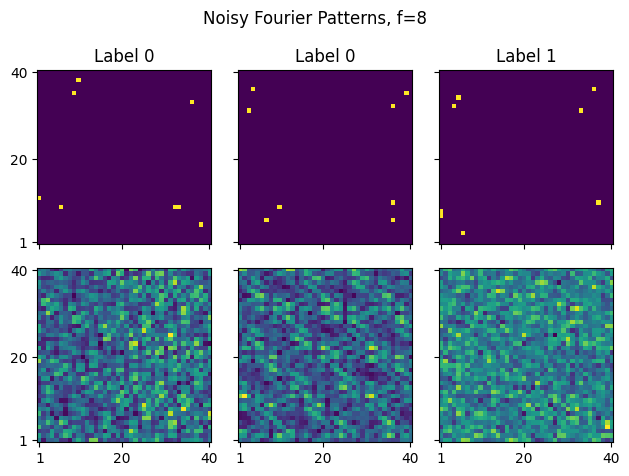

In [223]:
L = 40; N = 3; f = 8; clamp = L // 2
ticks = np.array([0, L//2-1, L-1])
x, y, x_dot = gen_NFP_data(L, N, f=8, clamp=L//2)
fig, axs = plt.subplots(ncols=N, nrows=2, sharey= True, sharex=True)

for i, j in product(range(2), range(N)):
    axs[i, j].imshow(np.abs(x_dot[j, 0]) if i == 0 else x[j, 0], origin='lower')
    if i == 0:
        axs[i, j].set_title(f"Label {int(y[j].item())}")
    axs[i, j].set_xticks(ticks); axs[i, j].set_xticklabels(ticks+1)
    axs[i, j].set_yticks(ticks); axs[i, j].set_yticklabels(ticks+1)

fig.suptitle(f"Noisy Fourier Patterns, f={f}")
fig.tight_layout()
plt.show()

### Generating test data

In [237]:
# Reset number generation
np.random.seed(0)
torch.manual_seed(0)

# Create test sets
te_loaders = []
for i, L in enumerate(Ls):

    if task_name == "DO1":
        x, y = gen_DOP_data(L, N_te, 1)
    elif task_name == "DO2":
        x, y = gen_DOP_data(L, N_te, 2)
    elif task_name == "NFP":
        x, y, _ = gen_NFP_data(L, N_te, f, clamp=L//2)
    
    # Batch test sets so it can fit on GPU (no need to shuffle, this is just test set.)
    te_loaders += [DataLoader(TensorDataset(x, y), batch_size=batch_size)]

## Training

In [238]:
# Print log
print(f"Training {architecture} on task {task_name} with Adam optimizer and learning rate {learning_rate} to accuracy {epsilon}. Image range {Ls} : ")

# Reset number generation
np.random.seed(0)
torch.manual_seed(0)

# Model loader object
loader = ModelLoader()

# Perform the experiment multiple times
for e in range(estimates):

    print(f"Run {e} / {estimates}")

    # Over every image size
    for i, L in enumerate(Ls):

        # Generate dataset and dataloaders
        print(f"Image size {L}")
        
        # Load model
        model_options = {'input_shape': input_shapes[i], 'out_channels': cnn_out_chans}

        # Parameter-fair FCNN options
        if architecture == "FCNN":
            
            # Create reference CNN
            cnn = loader.load("CNN", "ReLU", {'input_shape': input_shapes[i], 'out_channels': cnn_out_chans})
            cnn_param_count = sum(p.numel() for p in cnn.parameters())
            hidden_neurons = max(1, int(cnn_param_count / (L**2 + 1)))
            print("Number of hidden_neurons", hidden_neurons)

            # Set number of hidden neurons to match CNN
            model_options['hidden_neurons'] = hidden_neurons

        model = loader.load(architecture, activation, model_options).to(device)

        # Print number of parameters
        print("Generated", architecture, "with", count_parameters(model), "parameters")
        
        # Optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        criterion = nn.BCELoss()

        # Training loop
        
        tr_loss_req = 0.5
        tr_step = 0
        finished = False
        while not finished:
            
            # Generate fresh data
            if task_name == "DO1":
                x, y = gen_DOP_data(L, batch_size, 1)
            elif task_name == "DO2":
                x, y = gen_DOP_data(L, batch_size, 2)
            elif task_name == "NFP":
                x, y, _ = gen_NFP_data(L, batch_size, f, clamp=L//2)
            x, y = x.to(device), y.to(device)

            # Forward and backward step
            model.train()
            optimizer.zero_grad()
            output = model(x)
            tr_loss = criterion(output, y)
            tr_loss.backward()
            optimizer.step()

            # Print for logging purposes (underfitting, overfitting)
            if tr_loss.item() > 1 or tr_loss.item() < 0.05:
                print("Train loss:", tr_loss.item())

            # Evaluate when tr_loss is small
            accuracy = 0.0
            if tr_loss.item() < tr_loss_req:
                with torch.no_grad():
                    model.eval()
                    for x, y in te_loaders[i]:
                        
                        x, y = x.to(device), y.to(device)
                        output = model(x)
                        accuracy += sum(torch.eq((output>0.5).to(float), y)).item()
                    accuracy /= N_te
                print(f"Current accuracy: {accuracy}")
                tr_loss_req = max(0.01, tr_loss_req - 0.025)

            # Check goal
            tr_step += 1
            if accuracy > epsilon:
                print(f"Reached accuracy: {accuracy} in {tr_step} batches of size {batch_size}.")
                finished = True

        # Save results
        with open(filepath, 'rb') as file:
            results = pickle.load(file)

        # Add experiment to results
        results[(arch_name, L**2)] = (results.get((arch_name, L**2)) or []) + [tr_step * batch_size]

        # Write training set size to file
        with open(filepath, 'wb') as file:
            pickle.dump(results, file)
            
        # Print progress
        print(f"Progress: {i+1} / {len(Ls)}")

Training FCNN on task NFP with Adam optimizer and learning rate 0.005 to accuracy 0.8. Image range [10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40] : 
Run 0 / 5
Image size 10
Number of hidden_neurons 346
Generated FCNN with 35293 parameters
Current accuracy: 0.717
Current accuracy: 0.709
Current accuracy: 0.744
Current accuracy: 0.777
Current accuracy: 0.771
Current accuracy: 0.792
Current accuracy: 0.78
Current accuracy: 0.799
Current accuracy: 0.834
Reached accuracy: 0.834 in 392 batches of size 64.
Progress: 1 / 16
Image size 12
Number of hidden_neurons 317
Generated FCNN with 46283 parameters
Current accuracy: 0.675
Current accuracy: 0.682
Current accuracy: 0.724
Current accuracy: 0.727
Current accuracy: 0.758
Current accuracy: 0.784
Current accuracy: 0.794
Current accuracy: 0.821
Reached accuracy: 0.821 in 520 batches of size 64.
Progress: 2 / 16
Image size 14
Number of hidden_neurons 299
Generated FCNN with 59203 parameters
Current accuracy: 0.703
Current accuracy: 0.715
Current

## Polynomial fitting

Now we perform model fitting to estimate the sample complexity gap. 

In [239]:
# The function to fit
def polynomial(x, a, b):
    return a*(x**b)

# The bounds on the coefficients
bounds = (0, np.inf)

In [243]:
results_paths = ["results/backup/taskDO1_acc0.8_freq8.pkl", "results/backup/taskDO2_acc0.8_freq8.pkl", "results/backup/taskNFP_acc0.8_freq8.pkl"]

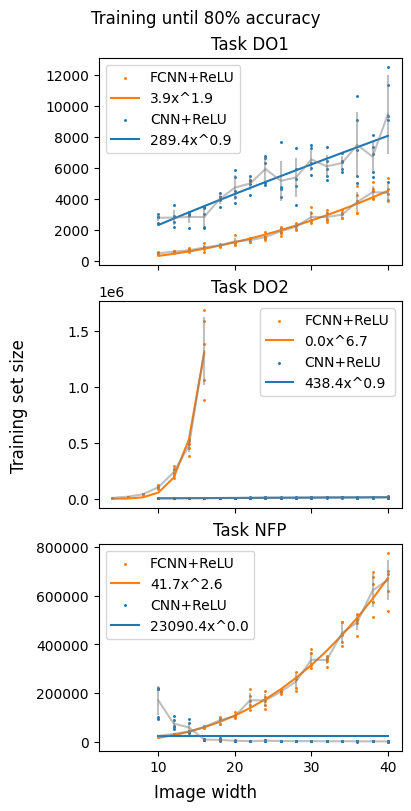

In [267]:
# Set up figures from all experiments
fig, axs = plt.subplots(nrows=3, layout='constrained', sharex=True)

# Plot colours
colordict = {"FCNN+ReLU":'tab:orange', "CNN+ReLU":'tab:blue'}

# Paths
for j, path in enumerate(results_paths):

    # Load data
    with open(path, 'rb') as file:
        sample_complexity = pickle.load(file)

    # Extract data to plot
    names = set([name for name, _ in sample_complexity.keys()])

    # For every model, make line plot
    for i, name in enumerate(names):
        
        # Plot training samples
        xs, ys, means, stds = unpack_and_aggregate(sample_complexity, name, [np.mean, np.std])
        axs[j].scatter(xs, ys, marker='.', s=5, linestyle='-', label=name, color=colordict[name])
        axs[j].legend()
        
        # Plot mean and standard deviation of traing samples
        axs[j].errorbar(np.unique(xs), means, stds, color=(0.5, 0.5, 0.5, 0.5))

        # Plot polynomial estimates
        fitted, covariance = curve_fit(polynomial, xs, ys, p0=[1, 1], bounds=bounds)
        axs[j].plot(xs, polynomial(xs, *fitted), label="{:.1f}x^{:.1f}".format(fitted[0], fitted[1]), color=colordict[name])
        axs[j].legend()

        # Title
        axs[j].set_title(f"Task {path[19:22]}")

# Plot graphics
fig.supxlabel('Image width')
fig.supylabel('Training set size')
fig.set_size_inches(4, 8)
#plt.legend()
#plt.xticks(ticks=[tick for tick in plt.xticks()[0]][1::2], labels=[tick for tick in plt.xticks()[1]][1::2])
fig.suptitle("Training until 80% accuracy")
#plt.grid(True)

# Show the plot
plt.show()

## Discussion

# References

1. [[paper][1]] Nick Harvey, Chris Liaw, Abbas Meharbian. "Nearly-tight VC-dimension bounds for piecewise linear neural networks". *Conference on learning theory*. PMLR, 2017.

2. [[paper][2]] Brutzkus, Alon, Amir Globerson. "An optimization and generalization analysis for max-pooling networks." *Uncertainty in Artificial Intelligence*. PMLR, 2021.

[1]: https://www.cs.ubc.ca/~nickhar/papers/NeuralNets/NN-Arxiv.pdf
[2]: https://arxiv.org/pdf/2002.09781.pdf